In [14]:
from imutils import face_utils
import numpy as np
import imutils
import dlib
import cv2
import matplotlib.pyplot as plt
import face_recognition
import os
from imutils import paths
from PIL import Image

def imshow(tit, image) :
    plt.title(tit)    
    if len(image.shape) == 3 :
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    else :
        plt.imshow(image, cmap="gray")
    plt.show()

In [15]:
# http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
detector = dlib.get_frontal_face_detector()

In [16]:
img = Image.open("./imgs/no_makeup/xfsy_0068.png") 

frame = cv2.imread("./imgs/no_makeup/xfsy_0068.png")
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
rects = detector(gray, 0)  
print("Number of faces detected: {}".format(len(rects)))
for r in rects :
    print(r)

Number of faces detected: 1
[(22, 50) (280, 308)]


Detection 0: Left: 22 Top: 50 Right: 280 Bottom: 308


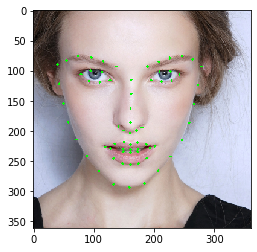

In [17]:
for k, d in enumerate(rects):
        print("Detection {}: Left: {} Top: {} Right: {} Bottom: {}".format(
            k, d.left(), d.top(), d.right(), d.bottom()))
        shape = predictor(gray, d)
        shape = face_utils.shape_to_np(shape) #객체 내에서 필요한 좌표 정보만 넘파이 객체로 뽑음
        for (x, y) in shape:
          cv2.circle(frame, (x, y), 2, (0, 255, 0), -1)

imshow("", frame)

In [18]:
point1 = ((shape[58] + shape[9])*0.5).round()  # point1 턱 (밑입술 하단 - 턱끝 )
point2 = ((shape[3] + shape[49])*0.5).round()  # point2 왼쪽 뺨 (왼쪽 외곽선 - 왼쪽 입술 끝점)
point3 = ((shape[15] + shape[55])*0.5).round() # point3 오른쪽 뺨 (오른쪽 외곽선 - 오른쪽 입술 끝점)
point4 = shape[31].astype('float64')           # point4 코
point5 = ((shape[22] + shape[23])*0.5).round() # point5 눈썹 사이

In [19]:
# RGB 모드로 변경 
rgb_img = img.convert('RGB') 

# 지정한 좌표의 색상을 r,g,b 변수에 넣음 
r1, g1, b1 = rgb_img.getpixel((point1[0], point1[1]))
r2, g2, b2 = rgb_img.getpixel((point2[0], point2[1])) 
r3, g3, b3 = rgb_img.getpixel((point3[0], point3[1])) 
r4, g4, b4 = rgb_img.getpixel((point4[0], point4[1])) 
r5, g5, b5 = rgb_img.getpixel((point5[0], point5[1])) 

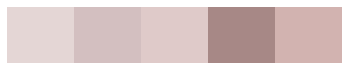

In [20]:
# point RGB값 보여주기

def plot_colors(hist, centroids):
    bar = np.zeros((50, 300, 3), dtype = "uint8")
    startX = 0

    for (percent, color) in zip(hist, centroids):
        endX = startX + (percent * 300)
        cv2.rectangle(bar, (int(startX), 0), (int(endX), 50),
            color.astype("uint8").tolist(), -1)
        startX = endX
    return bar


hist = np.array([0.2, 0.2, 0.2, 0.2, 0.2])
temp = np.array([[r1,g1,b1],[r2,g2,b2],[r3,g3,b3],[r4,g4,b4],[r5,g5,b5]])



bar = plot_colors(hist, temp)

plt.figure()
plt.axis("off")
plt.imshow(bar)
plt.show()

In [21]:
import colorsys

# RGB -> HSV
def revised_rgb_to_hsv(r, g, b):
    (h, s, v) = colorsys.rgb_to_hsv(r/255, g/255, b/255)
    h *= 360
    s *= 100
    v *= 100
    return round(h), round(s), round(v)

h1, s1, v1 = revised_rgb_to_hsv(r1, g1, b1)
h2, s2, v2 = revised_rgb_to_hsv(r2, g2, b2)
h3, s3, v3 = revised_rgb_to_hsv(r3, g3, b3)
h4, s4, v4 = revised_rgb_to_hsv(r4, g4, b4)
h5, s5, v5 = revised_rgb_to_hsv(r5, g5, b5)

In [2]:
import pandas as pd

# 데이터로 예측
data = pd.read_excel('data2.xlsx', index_col='순번')

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


x_data = data[['H', 'S', 'V']]
y_data = data['쿨웜']

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.1, random_state=777)


# 정규화
scaler = MinMaxScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = LogisticRegression()

model.fit(x_train, y_train)


print(model.score(x_test, y_test))

0.7222222222222222


In [25]:
hsv1 = np.array([h1, s1, v1])
hsv2 = np.array([h2, s2, v2])
hsv3 = np.array([h3, s3, v3])
hsv4 = np.array([h4, s4, v4])
hsv5 = np.array([h5, s5, v5])

sample = np.array([hsv1, hsv2, hsv3, hsv4, hsv5])

#정규화
sample = scaler.transform(sample)

In [26]:
predict = model.predict(sample)
predict_proba = model.predict_proba(sample)
print(predict)
print(predict_proba)

[1 0 1 1 1]
[[0.45358223 0.54641777]
 [0.87363874 0.12636126]
 [0.43607085 0.56392915]
 [0.38115562 0.61884438]
 [0.40720189 0.59279811]]


In [28]:
predict.sum()

4

In [37]:
(predict_proba.sum(axis=0)[0])*20

# 문제점 : prodict에서 과반이 [1:웜톤]으로 판정했으나, 
#         쿨톤 판정값 중 높은 값이 있어서 평균값 퍼센테이지로는 [0:쿨톤]으로 판정 됨.
# 개선방법 1. 과반으로 판정 된 값만 평균 내기
# 개선방법 2. 극단값 제거

51.03298656412613

In [ ]:
if predict.sum() >= 3:
    print("웜톤일 확률이 {:.2f}% 입니다.".format((predict_proba.sum(axis=0)[0])*20))
else:
    print("쿨톤일 확률이 {:.2f}% 입니다.".format((predict_proba.sum(axis=0)[0])*20))